# Point cloud segmentation with PointNet

**Author:** [Soumik Rakshit](https://github.com/soumik12345), [Sayak Paul](https://github.com/sayakpaul)<br>
**Date created:** 2020/10/23<br>
**Last modified:** 2020/10/24<br>
**Description:** Implementation of a PointNet-based model for segmenting point clouds.

## Introduction

A "point cloud" is an important type of data structure for storing geometric shape data.
Due to its irregular format, it's often transformed into
regular 3D voxel grids or collections of images before being used in deep learning applications,
a step which makes the data unnecessarily large.
The PointNet family of models solves this problem by directly consuming point clouds, respecting
the permutation-invariance property of the point data. The PointNet family of
models provides a simple, unified architecture
for applications ranging from **object classification**, **part segmentation**, to
**scene semantic parsing**.

In this example, we demonstrate the implementation of the PointNet architecture
for shape segmentation.

### References

- [PointNet: Deep Learning on Point Sets for 3D Classification and Segmentation](https://arxiv.org/abs/1612.00593)
- [Point cloud classification with PointNet](https://keras.io/examples/vision/pointnet/)
- [Spatial Transformer Networks](https://arxiv.org/abs/1506.02025)

## Imports

In [11]:
import os
import json
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt

## Downloading Dataset

The [ShapeNet dataset](https://shapenet.org/) is an ongoing effort to establish a richly-annotated,
large-scale dataset of 3D shapes. **ShapeNetCore** is a subset of the full ShapeNet
dataset with clean single 3D models and manually verified category and alignment
annotations. It covers 55 common object categories, with about 51,300 unique 3D models.

For this example, we use one of the 12 object categories of
[PASCAL 3D+](http://cvgl.stanford.edu/projects/pascal3d.html),
included as part of the ShapenetCore dataset.

In [12]:
dataset_url = "https://git.io/JiY4i"

dataset_path = keras.utils.get_file(
    fname="shapenet.zip",
    origin=dataset_url,
    cache_subdir="datasets",
    hash_algorithm="auto",
    extract=True,
    archive_format="auto",
    cache_dir="datasets",
)

## Loading the dataset

We parse the dataset metadata in order to easily map model categories to their
respective directories and segmentation classes to colors for the purpose of
visualization.

In [13]:
with open("/tmp/.keras/datasets/PartAnnotation/metadata.json") as json_file:
    metadata = json.load(json_file)

print(metadata)

{'Airplane': {'directory': '02691156', 'lables': ['wing', 'body', 'tail', 'engine'], 'colors': ['blue', 'green', 'red', 'pink']}, 'Bag': {'directory': '02773838', 'lables': ['handle', 'body'], 'colors': ['blue', 'green']}, 'Cap': {'directory': '02954340', 'lables': ['panels', 'peak'], 'colors': ['blue', 'green']}, 'Car': {'directory': '02958343', 'lables': ['wheel', 'hood', 'roof'], 'colors': ['blue', 'green', 'red']}, 'Chair': {'directory': '03001627', 'lables': ['leg', 'arm', 'back', 'seat'], 'colors': ['blue', 'green', 'red', 'pink']}, 'Earphone': {'directory': '03261776', 'lables': ['earphone', 'headband'], 'colors': ['blue', 'green']}, 'Guitar': {'directory': '03467517', 'lables': ['head', 'body', 'neck'], 'colors': ['blue', 'green', 'red']}, 'Knife': {'directory': '03624134', 'lables': ['handle', 'blade'], 'colors': ['blue', 'green']}, 'Lamp': {'directory': '03636649', 'lables': ['canopy', 'lampshade', 'base'], 'colors': ['blue', 'green', 'red']}, 'Laptop': {'directory': '0364280

In this example, we train PointNet to segment the parts of an `Airplane` model.

In [14]:
points_dir = "/tmp/.keras/datasets/PartAnnotation/{}/points".format(
    metadata["Airplane"]["directory"]
)
labels_dir = "/tmp/.keras/datasets/PartAnnotation/{}/points_label".format(
    metadata["Airplane"]["directory"]
)
LABELS = metadata["Airplane"]["lables"]
COLORS = metadata["Airplane"]["colors"]

VAL_SPLIT = 0.2
NUM_SAMPLE_POINTS = 1024
BATCH_SIZE = 32
EPOCHS = 60
INITIAL_LR = 1e-3

## Structuring the dataset

We generate the following in-memory data structures from the Airplane point clouds and
their labels:

- `point_clouds` is a list of `np.array` objects that represent the point cloud data in
the form of x, y and z coordinates. Axis 0 represents the number of points in the
point cloud, while axis 1 represents the coordinates. `all_labels` is the list
that represents the label of each coordinate as a string (needed mainly for
visualization purposes).
- `test_point_clouds` is in the same format as `point_clouds`, but doesn't have
corresponding the labels of the point clouds.
- `all_labels` is a list of `np.array` objects that represent the point cloud labels
for each coordinate, corresponding to the `point_clouds` list.
- `point_cloud_labels` is a list of `np.array` objects that represent the point cloud
labels for each coordinate in one-hot encoded form, corresponding to the `point_clouds`
list.

In [16]:
point_clouds, test_point_clouds = [], []
point_cloud_labels, all_labels = [], []

points_files = glob(os.path.join(points_dir, "*.pts"))
for point_file in tqdm(points_files):
    point_cloud = np.loadtxt(point_file)
    if point_cloud.shape[0] < NUM_SAMPLE_POINTS:
        continue

    # Get the file-id of the current point cloud for parsing its
    # labels.
    file_id = point_file.split("/")[-1].split(".")[0]
    label_data, num_labels = {}, 0
    for label in LABELS:
        label_file = os.path.join(labels_dir, label, file_id + ".seg")
        if os.path.exists(label_file):
            label_data[label] = np.loadtxt(label_file).astype("float32")
            num_labels = len(label_data[label])

    # Point clouds having labels will be our training samples.
    try:
        label_map = ["none"] * num_labels
        for label in LABELS:
            for i, data in enumerate(label_data[label]):
                label_map[i] = label if data == 1 else label_map[i]
        label_data = [
            LABELS.index(label) if label != "none" else len(LABELS)
            for label in label_map
        ]
        # Apply one-hot encoding to the dense label representation.
        label_data = keras.utils.to_categorical(label_data, num_classes=len(LABELS) + 1)

        point_clouds.append(point_cloud)
        point_cloud_labels.append(label_data)
        all_labels.append(label_map)
    except KeyError:
        print(1)
        test_point_clouds.append(point_cloud)

  1%|          | 29/4045 [00:00<01:34, 42.60it/s]

1
1


  2%|▏         | 90/4045 [00:02<01:32, 42.73it/s]

1
1


  3%|▎         | 105/4045 [00:02<01:31, 43.20it/s]

1
1
1


  3%|▎         | 120/4045 [00:02<01:36, 40.75it/s]

1


  3%|▎         | 130/4045 [00:03<01:37, 40.18it/s]

1


  4%|▍         | 161/4045 [00:04<01:42, 38.07it/s]

1
1


  4%|▍         | 176/4045 [00:04<01:32, 41.72it/s]

1
1
1


  5%|▌         | 210/4045 [00:05<01:36, 39.74it/s]

1


  5%|▌         | 220/4045 [00:05<01:36, 39.58it/s]

1


  6%|▌         | 233/4045 [00:05<01:36, 39.52it/s]

1
1


  6%|▌         | 248/4045 [00:06<01:33, 40.62it/s]

1
1


  7%|▋         | 280/4045 [00:07<01:35, 39.59it/s]

1
1


  8%|▊         | 322/4045 [00:08<01:28, 41.93it/s]

1
1


  8%|▊         | 337/4045 [00:08<01:31, 40.36it/s]

1


  9%|▊         | 351/4045 [00:08<01:33, 39.59it/s]

1


 10%|█         | 408/4045 [00:10<01:37, 37.45it/s]

1


 10%|█         | 421/4045 [00:10<01:33, 38.60it/s]

1


 11%|█         | 446/4045 [00:11<01:27, 41.02it/s]

1
1


 12%|█▏        | 481/4045 [00:12<01:30, 39.20it/s]

1


 12%|█▏        | 491/4045 [00:12<01:25, 41.41it/s]

1
1


 12%|█▏        | 502/4045 [00:12<01:24, 42.11it/s]

1
1
1


 13%|█▎        | 519/4045 [00:13<01:36, 36.48it/s]

1


 13%|█▎        | 531/4045 [00:13<01:36, 36.44it/s]

1


 13%|█▎        | 544/4045 [00:13<01:32, 37.84it/s]

1


 14%|█▍        | 569/4045 [00:14<01:32, 37.47it/s]

1
1


 14%|█▍        | 578/4045 [00:14<01:30, 38.19it/s]

1
1


 15%|█▍        | 600/4045 [00:15<01:28, 39.01it/s]

1


 16%|█▌        | 634/4045 [00:16<01:22, 41.59it/s]

1
1
1


 16%|█▌        | 657/4045 [00:16<01:27, 38.78it/s]

1
1


 17%|█▋        | 678/4045 [00:17<01:26, 39.03it/s]

1


 17%|█▋        | 695/4045 [00:17<01:27, 38.49it/s]

1


 17%|█▋        | 707/4045 [00:18<01:25, 38.83it/s]

1


 18%|█▊        | 743/4045 [00:19<01:31, 35.95it/s]

1
1


 19%|█▉        | 768/4045 [00:19<01:25, 38.36it/s]

1


 20%|█▉        | 804/4045 [00:20<01:40, 32.25it/s]

1


 20%|██        | 813/4045 [00:21<01:32, 34.87it/s]

1
1


 21%|██        | 834/4045 [00:21<01:33, 34.46it/s]

1


 21%|██        | 846/4045 [00:22<01:30, 35.22it/s]

1


 22%|██▏       | 878/4045 [00:22<01:29, 35.42it/s]

1
1


 22%|██▏       | 896/4045 [00:23<01:20, 39.10it/s]

1
1


 23%|██▎       | 934/4045 [00:24<01:19, 39.23it/s]

1


 24%|██▍       | 966/4045 [00:25<01:20, 38.33it/s]

1


 25%|██▍       | 1003/4045 [00:26<01:15, 40.29it/s]

1
1


 25%|██▌       | 1013/4045 [00:26<01:15, 40.18it/s]

1
1
1


 27%|██▋       | 1076/4045 [00:28<01:14, 39.96it/s]

1
1
1


 27%|██▋       | 1089/4045 [00:28<01:15, 39.21it/s]

1


 27%|██▋       | 1106/4045 [00:28<01:10, 41.50it/s]

1
1


 28%|██▊       | 1137/4045 [00:29<01:15, 38.63it/s]

1
1


 28%|██▊       | 1150/4045 [00:30<01:12, 40.14it/s]

1


 30%|██▉       | 1201/4045 [00:31<01:11, 39.65it/s]

1
1
1


 30%|███       | 1214/4045 [00:31<01:08, 41.32it/s]

1


 30%|███       | 1229/4045 [00:32<01:09, 40.67it/s]

1


 31%|███       | 1239/4045 [00:32<01:10, 39.99it/s]

1


 31%|███       | 1262/4045 [00:32<01:07, 41.13it/s]

1
1


 31%|███▏      | 1267/4045 [00:32<01:08, 40.61it/s]

1


 32%|███▏      | 1282/4045 [00:33<01:14, 37.26it/s]

1
1


 32%|███▏      | 1295/4045 [00:33<01:10, 39.23it/s]

1
1


 32%|███▏      | 1309/4045 [00:34<01:08, 39.81it/s]

1


 33%|███▎      | 1334/4045 [00:34<01:08, 39.76it/s]

1


 33%|███▎      | 1347/4045 [00:35<01:06, 40.58it/s]

1


 34%|███▎      | 1357/4045 [00:35<01:05, 40.74it/s]

1
1


 34%|███▍      | 1367/4045 [00:35<01:07, 39.41it/s]

1


 34%|███▍      | 1376/4045 [00:35<01:08, 38.89it/s]

1
1


 34%|███▍      | 1389/4045 [00:36<01:06, 39.75it/s]

1
1
1


 35%|███▍      | 1407/4045 [00:36<01:07, 39.33it/s]

1


 35%|███▌      | 1416/4045 [00:36<01:06, 39.73it/s]

1


 35%|███▌      | 1434/4045 [00:37<01:03, 41.22it/s]

1
1
1


 36%|███▌      | 1459/4045 [00:37<01:05, 39.66it/s]

1
1


 37%|███▋      | 1486/4045 [00:38<01:07, 38.09it/s]

1


 37%|███▋      | 1498/4045 [00:38<01:07, 37.93it/s]

1


 38%|███▊      | 1518/4045 [00:39<01:14, 33.79it/s]

1


 38%|███▊      | 1542/4045 [00:40<01:06, 37.41it/s]

1


 38%|███▊      | 1555/4045 [00:40<01:03, 39.27it/s]

1
1


 39%|███▉      | 1597/4045 [00:41<01:02, 39.14it/s]

1
1
1
1


 40%|███▉      | 1616/4045 [00:42<01:01, 39.59it/s]

1


 40%|████      | 1632/4045 [00:42<01:04, 37.64it/s]

1


 41%|████      | 1648/4045 [00:42<01:07, 35.76it/s]

1


 41%|████      | 1660/4045 [00:43<01:06, 36.02it/s]

1


 41%|████      | 1668/4045 [00:43<01:04, 36.59it/s]

1


 41%|████▏     | 1677/4045 [00:43<01:01, 38.28it/s]

1
1


 42%|████▏     | 1691/4045 [00:44<01:01, 38.02it/s]

1
1


 42%|████▏     | 1699/4045 [00:44<01:03, 36.75it/s]

1


 42%|████▏     | 1709/4045 [00:44<01:01, 38.24it/s]

1


 43%|████▎     | 1721/4045 [00:44<01:00, 38.49it/s]

1


 43%|████▎     | 1730/4045 [00:45<00:58, 39.50it/s]

1


 43%|████▎     | 1751/4045 [00:45<01:02, 36.98it/s]

1


 44%|████▎     | 1760/4045 [00:45<00:59, 38.36it/s]

1


 44%|████▍     | 1774/4045 [00:46<00:55, 40.83it/s]

1
1


 45%|████▍     | 1814/4045 [00:47<01:01, 36.25it/s]

1


 45%|████▌     | 1823/4045 [00:47<00:58, 38.12it/s]

1
1


 45%|████▌     | 1832/4045 [00:47<00:56, 39.11it/s]

1


 46%|████▌     | 1849/4045 [00:48<00:58, 37.86it/s]

1
1


 46%|████▌     | 1866/4045 [00:48<00:56, 38.46it/s]

1


 46%|████▋     | 1879/4045 [00:49<00:56, 38.06it/s]

1


 47%|████▋     | 1899/4045 [00:49<00:56, 37.99it/s]

1


 47%|████▋     | 1911/4045 [00:49<00:56, 37.82it/s]

1


 47%|████▋     | 1919/4045 [00:50<00:55, 38.54it/s]

1
1
1
1
1


 48%|████▊     | 1935/4045 [00:50<00:52, 39.88it/s]

1


 48%|████▊     | 1959/4045 [00:51<00:57, 36.23it/s]

1
1


 49%|████▉     | 1984/4045 [00:51<00:53, 38.84it/s]

1
1


 49%|████▉     | 2001/4045 [00:52<00:52, 38.74it/s]

1


 50%|████▉     | 2014/4045 [00:52<01:00, 33.79it/s]

1
1


 50%|█████     | 2032/4045 [00:53<00:50, 40.01it/s]

1
1


 51%|█████     | 2052/4045 [00:53<00:50, 39.47it/s]

1


 51%|█████     | 2065/4045 [00:54<00:50, 39.56it/s]

1


 52%|█████▏    | 2087/4045 [00:54<00:49, 39.35it/s]

1


 52%|█████▏    | 2097/4045 [00:54<00:48, 40.20it/s]

1


 52%|█████▏    | 2118/4045 [00:55<00:49, 38.79it/s]

1


 53%|█████▎    | 2126/4045 [00:55<00:50, 37.84it/s]

1


 53%|█████▎    | 2144/4045 [00:56<00:48, 39.24it/s]

1
1


 53%|█████▎    | 2157/4045 [00:56<00:48, 38.88it/s]

1


 54%|█████▎    | 2170/4045 [00:56<00:48, 38.67it/s]

1


 54%|█████▍    | 2179/4045 [00:56<00:48, 38.59it/s]

1


 55%|█████▍    | 2208/4045 [00:57<00:48, 38.18it/s]

1


 55%|█████▌    | 2225/4045 [00:58<00:52, 34.86it/s]

1


 55%|█████▌    | 2239/4045 [00:58<00:46, 38.85it/s]

1
1


 56%|█████▌    | 2249/4045 [00:58<00:42, 42.22it/s]

1
1
1
1


 56%|█████▌    | 2274/4045 [00:59<00:42, 41.19it/s]

1
1


 56%|█████▋    | 2279/4045 [00:59<00:43, 40.21it/s]

1


 58%|█████▊    | 2337/4045 [01:01<00:44, 38.65it/s]

1
1


 58%|█████▊    | 2342/4045 [01:01<00:42, 40.10it/s]

1


 58%|█████▊    | 2356/4045 [01:01<00:43, 39.00it/s]

1


 59%|█████▊    | 2369/4045 [01:01<00:42, 39.65it/s]

1
1


 59%|█████▉    | 2402/4045 [01:02<00:42, 38.24it/s]

1


 60%|█████▉    | 2422/4045 [01:03<00:42, 38.20it/s]

1


 60%|██████    | 2443/4045 [01:03<00:41, 38.47it/s]

1
1


 62%|██████▏   | 2492/4045 [01:05<00:40, 38.20it/s]

1
1
1


 62%|██████▏   | 2505/4045 [01:05<00:38, 39.81it/s]

1


 62%|██████▏   | 2526/4045 [01:06<00:38, 39.12it/s]

1
1
1


 63%|██████▎   | 2540/4045 [01:06<00:37, 40.08it/s]

1
1
1


 63%|██████▎   | 2549/4045 [01:06<00:37, 39.57it/s]

1


 64%|██████▎   | 2578/4045 [01:07<00:39, 37.50it/s]

1


 64%|██████▍   | 2608/4045 [01:08<00:36, 39.79it/s]

1
1
1


 65%|██████▌   | 2633/4045 [01:09<00:36, 38.29it/s]

1
1


 65%|██████▌   | 2648/4045 [01:09<00:33, 41.19it/s]

1
1


 66%|██████▌   | 2663/4045 [01:09<00:35, 38.85it/s]

1


 66%|██████▌   | 2672/4045 [01:09<00:34, 39.29it/s]

1


 66%|██████▋   | 2683/4045 [01:10<00:31, 42.60it/s]

1
1
1
1


 67%|██████▋   | 2697/4045 [01:10<00:37, 35.96it/s]

1


 67%|██████▋   | 2730/4045 [01:11<00:33, 39.15it/s]

1


 68%|██████▊   | 2747/4045 [01:11<00:33, 38.41it/s]

1


 69%|██████▊   | 2777/4045 [01:12<00:31, 39.68it/s]

1
1
1


 69%|██████▉   | 2786/4045 [01:12<00:31, 39.63it/s]

1
1
1


 69%|██████▉   | 2801/4045 [01:13<00:29, 42.66it/s]

1
1
1


 69%|██████▉   | 2811/4045 [01:13<00:31, 39.62it/s]

1


 70%|███████   | 2839/4045 [01:14<00:31, 38.01it/s]

1
1
1


 71%|███████   | 2866/4045 [01:14<00:30, 39.17it/s]

1


 71%|███████▏  | 2887/4045 [01:15<00:29, 39.54it/s]

1


 72%|███████▏  | 2905/4045 [01:15<00:28, 40.12it/s]

1
1


 72%|███████▏  | 2920/4045 [01:16<00:28, 39.99it/s]

1


 72%|███████▏  | 2930/4045 [01:16<00:27, 40.12it/s]

1


 73%|███████▎  | 2944/4045 [01:17<00:31, 35.26it/s]

1
1


 74%|███████▎  | 2974/4045 [01:17<00:27, 38.85it/s]

1


 74%|███████▍  | 2995/4045 [01:18<00:27, 37.93it/s]

1


 74%|███████▍  | 3011/4045 [01:18<00:27, 37.90it/s]

1


 75%|███████▍  | 3024/4045 [01:19<00:25, 39.69it/s]

1
1


 75%|███████▌  | 3034/4045 [01:19<00:25, 40.37it/s]

1
1


 75%|███████▌  | 3049/4045 [01:19<00:24, 40.36it/s]

1
1
1
1


 76%|███████▋  | 3086/4045 [01:20<00:24, 39.87it/s]

1
1


 77%|███████▋  | 3114/4045 [01:21<00:24, 37.34it/s]

1


 77%|███████▋  | 3127/4045 [01:21<00:24, 37.49it/s]

1
1


 78%|███████▊  | 3139/4045 [01:22<00:24, 37.11it/s]

1
1


 78%|███████▊  | 3152/4045 [01:22<00:23, 38.40it/s]

1


 78%|███████▊  | 3164/4045 [01:22<00:24, 36.40it/s]

1
1


 79%|███████▉  | 3196/4045 [01:23<00:25, 33.92it/s]

1


 79%|███████▉  | 3208/4045 [01:24<00:23, 35.96it/s]

1


 80%|███████▉  | 3217/4045 [01:24<00:27, 30.40it/s]

1


 81%|████████  | 3274/4045 [01:25<00:20, 38.32it/s]

1
1


 81%|████████  | 3284/4045 [01:26<00:18, 40.16it/s]

1
1
1


 82%|████████▏ | 3313/4045 [01:26<00:18, 40.06it/s]

1


 83%|████████▎ | 3348/4045 [01:27<00:17, 39.53it/s]

1


 83%|████████▎ | 3369/4045 [01:28<00:17, 39.09it/s]

1


 84%|████████▎ | 3386/4045 [01:28<00:16, 40.81it/s]

1
1


 84%|████████▍ | 3404/4045 [01:29<00:16, 39.81it/s]

1


 84%|████████▍ | 3418/4045 [01:29<00:15, 40.36it/s]

1
1


 85%|████████▍ | 3436/4045 [01:30<00:15, 39.34it/s]

1
1


 85%|████████▌ | 3455/4045 [01:30<00:13, 42.16it/s]

1
1
1
1


 86%|████████▌ | 3465/4045 [01:30<00:16, 34.61it/s]

1
1


 86%|████████▌ | 3475/4045 [01:31<00:14, 38.35it/s]

1
1


 86%|████████▌ | 3483/4045 [01:31<00:14, 38.37it/s]

1


 86%|████████▋ | 3495/4045 [01:31<00:14, 37.69it/s]

1


 87%|████████▋ | 3504/4045 [01:31<00:14, 38.01it/s]

1


 87%|████████▋ | 3527/4045 [01:32<00:12, 39.97it/s]

1
1


 87%|████████▋ | 3537/4045 [01:32<00:12, 39.97it/s]

1
1


 89%|████████▊ | 3582/4045 [01:33<00:11, 39.49it/s]

1


 89%|████████▉ | 3596/4045 [01:34<00:11, 40.27it/s]

1
1


 89%|████████▉ | 3615/4045 [01:34<00:10, 41.48it/s]

1
1
1
1


 90%|████████▉ | 3630/4045 [01:34<00:09, 42.27it/s]

1
1
1


 90%|█████████ | 3657/4045 [01:35<00:09, 39.59it/s]

1
1


 91%|█████████ | 3671/4045 [01:36<00:09, 40.27it/s]

1


 91%|█████████ | 3690/4045 [01:36<00:09, 36.60it/s]

1
1


 91%|█████████▏| 3700/4045 [01:36<00:08, 40.18it/s]

1
1
1


 92%|█████████▏| 3740/4045 [01:37<00:07, 39.01it/s]

1


 93%|█████████▎| 3769/4045 [01:38<00:06, 40.05it/s]

1
1


 94%|█████████▎| 3786/4045 [01:39<00:06, 37.53it/s]

1


 94%|█████████▍| 3799/4045 [01:39<00:06, 38.17it/s]

1
1


 95%|█████████▌| 3845/4045 [01:40<00:05, 37.84it/s]

1


 95%|█████████▌| 3854/4045 [01:40<00:04, 39.22it/s]

1
1


 96%|█████████▌| 3868/4045 [01:41<00:04, 41.63it/s]

1
1
1
1
1


 96%|█████████▌| 3887/4045 [01:41<00:03, 41.63it/s]

1
1
1


 96%|█████████▋| 3897/4045 [01:41<00:03, 42.23it/s]

1
1


 97%|█████████▋| 3933/4045 [01:42<00:02, 40.66it/s]

1
1


 98%|█████████▊| 3947/4045 [01:43<00:02, 39.61it/s]

1
1


 98%|█████████▊| 3955/4045 [01:43<00:02, 38.71it/s]

1
1


 98%|█████████▊| 3975/4045 [01:43<00:02, 34.69it/s]

1
1


 99%|█████████▊| 3987/4045 [01:44<00:01, 30.28it/s]

1


 99%|█████████▉| 3999/4045 [01:44<00:01, 33.63it/s]

1


 99%|█████████▉| 4008/4045 [01:44<00:01, 36.13it/s]

1
1
1
1


100%|█████████▉| 4025/4045 [01:45<00:00, 36.57it/s]

1


100%|█████████▉| 4041/4045 [01:45<00:00, 36.85it/s]

1


100%|██████████| 4045/4045 [01:45<00:00, 38.17it/s]


Next, we take a look at some samples from the in-memory arrays we just generated:

In [17]:
for _ in range(5):
    i = random.randint(0, len(point_clouds) - 1)
    print(f"point_clouds[{i}].shape:", point_clouds[0].shape)
    print(f"point_cloud_labels[{i}].shape:", point_cloud_labels[0].shape)
    for j in range(5):
        print(
            f"all_labels[{i}][{j}]:",
            all_labels[i][j],
            f"\tpoint_cloud_labels[{i}][{j}]:",
            point_cloud_labels[i][j],
            "\n",
        )

point_clouds[3014].shape: (2702, 3)
point_cloud_labels[3014].shape: (2702, 5)
all_labels[3014][0]: body 	point_cloud_labels[3014][0]: [0. 1. 0. 0. 0.] 

all_labels[3014][1]: wing 	point_cloud_labels[3014][1]: [1. 0. 0. 0. 0.] 

all_labels[3014][2]: wing 	point_cloud_labels[3014][2]: [1. 0. 0. 0. 0.] 

all_labels[3014][3]: tail 	point_cloud_labels[3014][3]: [0. 0. 1. 0. 0.] 

all_labels[3014][4]: body 	point_cloud_labels[3014][4]: [0. 1. 0. 0. 0.] 

point_clouds[2774].shape: (2702, 3)
point_cloud_labels[2774].shape: (2702, 5)
all_labels[2774][0]: body 	point_cloud_labels[2774][0]: [0. 1. 0. 0. 0.] 

all_labels[2774][1]: wing 	point_cloud_labels[2774][1]: [1. 0. 0. 0. 0.] 

all_labels[2774][2]: body 	point_cloud_labels[2774][2]: [0. 1. 0. 0. 0.] 

all_labels[2774][3]: body 	point_cloud_labels[2774][3]: [0. 1. 0. 0. 0.] 

all_labels[2774][4]: body 	point_cloud_labels[2774][4]: [0. 1. 0. 0. 0.] 

point_clouds[2905].shape: (2702, 3)
point_cloud_labels[2905].shape: (2702, 5)
all_labels[2905]

Now, let's visualize some of the point clouds along with their labels.

In [ ]:

def visualize_data(point_cloud, labels):
    df = pd.DataFrame(
        data={
            "x": point_cloud[:, 0],
            "y": point_cloud[:, 1],
            "z": point_cloud[:, 2],
            "label": labels,
        }
    )
    fig = plt.figure(figsize=(15, 10))
    ax = plt.axes(projection="3d")
    for index, label in enumerate(LABELS):
        c_df = df[df["label"] == label]
        try:
            ax.scatter(
                c_df["x"], c_df["y"], c_df["z"], label=label, alpha=0.5, c=COLORS[index]
            )
        except IndexError:
            pass
    ax.legend()
    plt.show()


visualize_data(point_clouds[0], all_labels[0])
visualize_data(point_clouds[300], all_labels[300])

### Preprocessing

Note that all the point clouds that we have loaded consist of a variable number of points,
which makes it difficult for us to batch them together. In order to overcome this problem, we
randomly sample a fixed number of points from each point cloud. We also normalize the
point clouds in order to make the data scale-invariant.

In [ ]:
for index in tqdm(range(len(point_clouds))):
    current_point_cloud = point_clouds[index]
    current_label_cloud = point_cloud_labels[index]
    current_labels = all_labels[index]
    num_points = len(current_point_cloud)
    # Randomly sampling respective indices.
    sampled_indices = random.sample(list(range(num_points)), NUM_SAMPLE_POINTS)
    # Sampling points corresponding to sampled indices.
    sampled_point_cloud = np.array([current_point_cloud[i] for i in sampled_indices])
    # Sampling corresponding one-hot encoded labels.
    sampled_label_cloud = np.array([current_label_cloud[i] for i in sampled_indices])
    # Sampling corresponding labels for visualization.
    sampled_labels = np.array([current_labels[i] for i in sampled_indices])
    # Normalizing sampled point cloud.
    norm_point_cloud = sampled_point_cloud - np.mean(sampled_point_cloud, axis=0)
    norm_point_cloud /= np.max(np.linalg.norm(norm_point_cloud, axis=1))
    point_clouds[index] = norm_point_cloud
    point_cloud_labels[index] = sampled_label_cloud
    all_labels[index] = sampled_labels

Let's visualize the sampled and normalized point clouds along with their corresponding
labels.

In [ ]:
visualize_data(point_clouds[0], all_labels[0])
visualize_data(point_clouds[300], all_labels[300])

### Creating TensorFlow datasets

We create `tf.data.Dataset` objects for the training and validation data.
We also augment the training point clouds by applying random jitter to them.

In [ ]:

def load_data(point_cloud_batch, label_cloud_batch):
    point_cloud_batch.set_shape([NUM_SAMPLE_POINTS, 3])
    label_cloud_batch.set_shape([NUM_SAMPLE_POINTS, len(LABELS) + 1])
    return point_cloud_batch, label_cloud_batch


def augment(point_cloud_batch, label_cloud_batch):
    noise = tf.random.uniform(
        tf.shape(label_cloud_batch), -0.005, 0.005, dtype=tf.float64
    )
    point_cloud_batch += noise[:, :, :3]
    return point_cloud_batch, label_cloud_batch


def generate_dataset(point_clouds, label_clouds, is_training=True):
    dataset = tf.data.Dataset.from_tensor_slices((point_clouds, label_clouds))
    dataset = dataset.shuffle(BATCH_SIZE * 100) if is_training else dataset
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size=BATCH_SIZE)
    dataset = (
        dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
        if is_training
        else dataset
    )
    return dataset


split_index = int(len(point_clouds) * (1 - VAL_SPLIT))
train_point_clouds = point_clouds[:split_index]
train_label_cloud = point_cloud_labels[:split_index]
total_training_examples = len(train_point_clouds)

val_point_clouds = point_clouds[split_index:]
val_label_cloud = point_cloud_labels[split_index:]

print("Num train point clouds:", len(train_point_clouds))
print("Num train point cloud labels:", len(train_label_cloud))
print("Num val point clouds:", len(val_point_clouds))
print("Num val point cloud labels:", len(val_label_cloud))

train_dataset = generate_dataset(train_point_clouds, train_label_cloud)
val_dataset = generate_dataset(val_point_clouds, val_label_cloud, is_training=False)

print("Train Dataset:", train_dataset)
print("Validation Dataset:", val_dataset)

## PointNet model

The figure below depicts the internals of the PointNet model family:

![](https://i.imgur.com/qFLNw5L.png)

Given that PointNet is meant to consume an ***unordered set*** of coordinates as its input data,
its architecture needs to match the following characteristic properties
of point cloud data:

### Permutation invariance

Given the unstructured nature of point cloud data, a scan made up of `n` points has `n!`
permutations. The subsequent data processing must be invariant to the different
representations. In order to make PointNet invariant to input permutations, we use a
symmetric function (such as max-pooling) once the `n` input points are mapped to
higher-dimensional space. The result is a **global feature vector** that aims to capture
an aggregate signature of the `n` input points. The global feature vector is used alongside
local point features for segmentation.

![](https://i.imgur.com/0mrvvjb.png)

### Transformation invariance

Segmentation outputs should be unchanged if the object undergoes certain transformations,
such as translation or scaling. For a given input point cloud, we apply an appropriate
rigid or affine transformation to achieve pose normalization. Because each of the `n` input
points are represented as a vector and are mapped to the embedding spaces independently,
applying a geometric transformation simply amounts to matrix multiplying each point with
a transformation matrix. This is motivated by the concept of
[Spatial Transformer Networks](https://arxiv.org/abs/1506.02025).

The operations comprising the T-Net are motivated by the higher-level architecture of
PointNet. MLPs (or fully-connected layers) are used to map the input points independently
and identically to a higher-dimensional space; max-pooling is used to encode a global
feature vector whose dimensionality is then reduced with fully-connected layers. The
input-dependent features at the final fully-connected layer are then combined with
globally trainable weights and biases, resulting in a 3-by-3 transformation matrix.

![](https://i.imgur.com/aEj3GYi.png)

### Point interactions

The interaction between neighboring points often carries useful information (i.e., a
single point should not be treated in isolation). Whereas classification need only make
use of global features, segmentation must be able to leverage local point features along
with global point features.


**Note**: The figures presented in this section have been taken from the
[original paper](https://arxiv.org/abs/1612.00593).

Now that we know the pieces that compose the PointNet model, we can implement the model.
We start by implementing the basic blocks i.e., the convolutional block and the multi-layer
perceptron block.

In [ ]:

def conv_block(x: tf.Tensor, filters: int, name: str) -> tf.Tensor:
    x = layers.Conv1D(filters, kernel_size=1, padding="valid", name=f"{name}_conv")(x)
    x = layers.BatchNormalization(momentum=0.0, name=f"{name}_batch_norm")(x)
    return layers.Activation("relu", name=f"{name}_relu")(x)


def mlp_block(x: tf.Tensor, filters: int, name: str) -> tf.Tensor:
    x = layers.Dense(filters, name=f"{name}_dense")(x)
    x = layers.BatchNormalization(momentum=0.0, name=f"{name}_batch_norm")(x)
    return layers.Activation("relu", name=f"{name}_relu")(x)


We implement a regularizer (taken from
[this example](https://keras.io/examples/vision/pointnet/#build-a-model))
to enforce orthogonality in the feature space. This is needed to ensure
that the magnitudes of the transformed features do not vary too much.

In [ ]:

class OrthogonalRegularizer(keras.regularizers.Regularizer):
    """Reference: https://keras.io/examples/vision/pointnet/#build-a-model"""

    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.identity = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.identity))

    def get_config(self):
        config = super(TransformerEncoder, self).get_config()
        config.update({"num_features": self.num_features, "l2reg_strength": self.l2reg})
        return config


The next piece is the transformation network which we explained earlier.

In [ ]:

def transformation_net(inputs: tf.Tensor, num_features: int, name: str) -> tf.Tensor:
    """
    Reference: https://keras.io/examples/vision/pointnet/#build-a-model.

    The `filters` values come from the original paper:
    https://arxiv.org/abs/1612.00593.
    """
    x = conv_block(inputs, filters=64, name=f"{name}_1")
    x = conv_block(x, filters=128, name=f"{name}_2")
    x = conv_block(x, filters=1024, name=f"{name}_3")
    x = layers.GlobalMaxPooling1D()(x)
    x = mlp_block(x, filters=512, name=f"{name}_1_1")
    x = mlp_block(x, filters=256, name=f"{name}_2_1")
    return layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=keras.initializers.Constant(np.eye(num_features).flatten()),
        activity_regularizer=OrthogonalRegularizer(num_features),
        name=f"{name}_final",
    )(x)


def transformation_block(inputs: tf.Tensor, num_features: int, name: str) -> tf.Tensor:
    transformed_features = transformation_net(inputs, num_features, name=name)
    transformed_features = layers.Reshape((num_features, num_features))(
        transformed_features
    )
    return layers.Dot(axes=(2, 1), name=f"{name}_mm")([inputs, transformed_features])


Finally, we piece the above blocks together and implement the segmentation model.

In [ ]:

def get_shape_segmentation_model(num_points: int, num_classes: int) -> keras.Model:
    input_points = keras.Input(shape=(None, 3))

    # PointNet Classification Network.
    transformed_inputs = transformation_block(
        input_points, num_features=3, name="input_transformation_block"
    )
    features_64 = conv_block(transformed_inputs, filters=64, name="features_64")
    features_128_1 = conv_block(features_64, filters=128, name="features_128_1")
    features_128_2 = conv_block(features_128_1, filters=128, name="features_128_2")
    transformed_features = transformation_block(
        features_128_2, num_features=128, name="transformed_features"
    )
    features_512 = conv_block(transformed_features, filters=512, name="features_512")
    features_2048 = conv_block(features_512, filters=2048, name="pre_maxpool_block")
    global_features = layers.MaxPool1D(pool_size=num_points, name="global_features")(
        features_2048
    )
    global_features = tf.tile(global_features, [1, num_points, 1])

    # Segmentation head.
    segmentation_input = layers.Concatenate(name="segmentation_input")(
        [
            features_64,
            features_128_1,
            features_128_2,
            transformed_features,
            features_512,
            global_features,
        ]
    )
    segmentation_features = conv_block(
        segmentation_input, filters=128, name="segmentation_features"
    )
    outputs = layers.Conv1D(
        num_classes, kernel_size=1, activation="softmax", name="segmentation_head"
    )(segmentation_features)
    return keras.Model(input_points, outputs)


## Instantiate the model

In [ ]:
x, y = next(iter(train_dataset))

num_points = x.shape[1]
num_classes = y.shape[-1]

segmentation_model = get_shape_segmentation_model(num_points, num_classes)
segmentation_model.summary()

## Training

For the training the authors recommend using a learning rate schedule that decays the
initial learning rate by half every 20 epochs. In this example, we resort to 15 epochs.

In [ ]:
training_step_size = total_training_examples // BATCH_SIZE
total_training_steps = training_step_size * EPOCHS
print(f"Total training steps: {total_training_steps}.")

lr_schedule = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[training_step_size * 15, training_step_size * 15],
    values=[INITIAL_LR, INITIAL_LR * 0.5, INITIAL_LR * 0.25],
)

steps = tf.range(total_training_steps, dtype=tf.int32)
lrs = [lr_schedule(step) for step in steps]

plt.plot(lrs)
plt.xlabel("Steps")
plt.ylabel("Learning Rate")
plt.show()

Finally, we implement a utility for running our experiments and launch model training.

In [ ]:

def run_experiment(epochs):

    segmentation_model = get_shape_segmentation_model(num_points, num_classes)
    segmentation_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=["accuracy"],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
    )

    history = segmentation_model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        callbacks=[checkpoint_callback],
    )

    segmentation_model.load_weights(checkpoint_filepath)
    return segmentation_model, history


segmentation_model, history = run_experiment(epochs=EPOCHS)

## Visualize the training landscape

In [ ]:

def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("accuracy")

## Inference

In [ ]:
validation_batch = next(iter(val_dataset))
val_predictions = segmentation_model.predict(validation_batch[0])
print(f"Validation prediction shape: {val_predictions.shape}")


def visualize_single_point_cloud(point_clouds, label_clouds, idx):
    label_map = LABELS + ["none"]
    point_cloud = point_clouds[idx]
    label_cloud = label_clouds[idx]
    visualize_data(point_cloud, [label_map[np.argmax(label)] for label in label_cloud])


idx = np.random.choice(len(validation_batch[0]))
print(f"Index selected: {idx}")

# Plotting with ground-truth.
visualize_single_point_cloud(validation_batch[0], validation_batch[1], idx)

# Plotting with predicted labels.
visualize_single_point_cloud(validation_batch[0], val_predictions, idx)

## Final notes

If you are interested in learning more about this topic, you may find
[this repository](https://github.com/soumik12345/point-cloud-segmentation)
useful.

In [1]:
import os
import json
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt

2022-08-10 19:45:01.582933: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
dataset_url = "https://git.io/JiY4i"

dataset_path = keras.utils.get_file(
    fname="shapenet.zip",
    origin=dataset_url,
    cache_subdir="datasets",
    hash_algorithm="auto",
    extract=True,
    archive_format="auto",
    cache_dir="datasets",
)

1078925405/1078925405 [==============================] - 127s 0us/step


In [3]:
points_dir = "/tmp/.keras/datasets/PartAnnotation/{}/points".format(
    metadata["Airplane"]["directory"]
)
labels_dir = "/tmp/.keras/datasets/PartAnnotation/{}/ma".format(
    metadata["Airplane"]["directory"]
)
LABELS = metadata["Airplane"]["lables"]
COLORS = metadata["Airplane"]["colors"]

VAL_SPLIT = 0.2
NUM_SAMPLE_POINTS = 1024
BATCH_SIZE = 32
EPOCHS = 60
INITIAL_LR = 1e-3

NameError: name 'metadata' is not defined

In [5]:
point_clouds, test_point_clouds = [], []
point_cloud_labels, all_labels = [], []

points_files = glob(os.path.join(points_dir, "*.pts"))
for point_file in tqdm(points_files):
    point_cloud = np.loadtxt(point_file)
    if point_cloud.shape[0] < NUM_SAMPLE_POINTS:
        continue

    # Get the file-id of the current point cloud for parsing its
    # labels.
    file_id = point_file.split("/")[-1].split(".")[0]
    label_data, num_labels = {}, 0
    for label in LABELS:
        label_file = os.path.join(labels_dir, label, file_id + ".seg")
        if os.path.exists(label_file):
            label_data[label] = np.loadtxt(label_file).astype("float32")
            num_labels = len(label_data[label])

    # Point clouds having labels will be our training samples.
    try:
        label_map = ["none"] * num_labels
        for label in LABELS:
            for i, data in enumerate(label_data[label]):
                label_map[i] = label if data == 1 else label_map[i]
        label_data = [
            LABELS.index(label) if label != "none" else len(LABELS)
            for label in label_map
        ]
        # Apply one-hot encoding to the dense label representation.
        label_data = keras.utils.to_categorical(label_data, num_classes=len(LABELS) + 1)

        point_clouds.append(point_cloud)
        point_cloud_labels.append(label_data)
        all_labels.append(label_map)
    except KeyError:
        test_point_clouds.append(point_cloud)

100%|██████████| 4045/4045 [01:43<00:00, 39.20it/s]


In [6]:
for _ in range(5):
    i = random.randint(0, len(point_clouds) - 1)
    print(f"point_clouds[{i}].shape:", point_clouds[0].shape)
    print(f"point_cloud_labels[{i}].shape:", point_cloud_labels[0].shape)
    for j in range(5):
        print(
            f"all_labels[{i}][{j}]:",
            all_labels[i][j],
            f"\tpoint_cloud_labels[{i}][{j}]:",
            point_cloud_labels[i][j],
            "\n",
        )

point_clouds[3040].shape: (2702, 3)
point_cloud_labels[3040].shape: (2702, 5)
all_labels[3040][0]: engine 	point_cloud_labels[3040][0]: [0. 0. 0. 1. 0.] 

all_labels[3040][1]: wing 	point_cloud_labels[3040][1]: [1. 0. 0. 0. 0.] 

all_labels[3040][2]: engine 	point_cloud_labels[3040][2]: [0. 0. 0. 1. 0.] 

all_labels[3040][3]: body 	point_cloud_labels[3040][3]: [0. 1. 0. 0. 0.] 

all_labels[3040][4]: body 	point_cloud_labels[3040][4]: [0. 1. 0. 0. 0.] 

point_clouds[3135].shape: (2702, 3)
point_cloud_labels[3135].shape: (2702, 5)
all_labels[3135][0]: tail 	point_cloud_labels[3135][0]: [0. 0. 1. 0. 0.] 

all_labels[3135][1]: body 	point_cloud_labels[3135][1]: [0. 1. 0. 0. 0.] 

all_labels[3135][2]: wing 	point_cloud_labels[3135][2]: [1. 0. 0. 0. 0.] 

all_labels[3135][3]: body 	point_cloud_labels[3135][3]: [0. 1. 0. 0. 0.] 

all_labels[3135][4]: engine 	point_cloud_labels[3135][4]: [0. 0. 0. 1. 0.] 

point_clouds[2917].shape: (2702, 3)
point_cloud_labels[2917].shape: (2702, 5)
all_labels

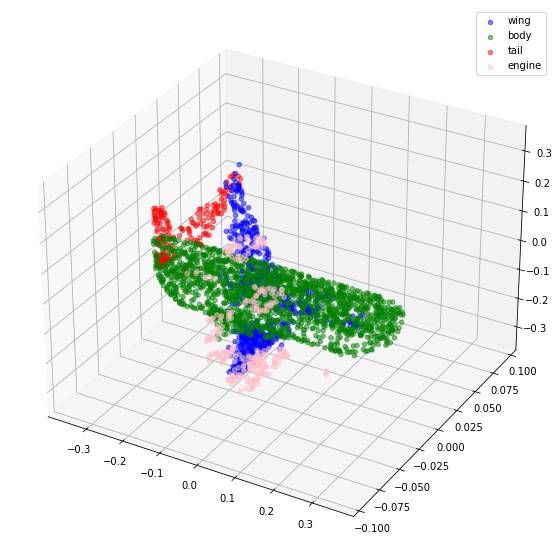

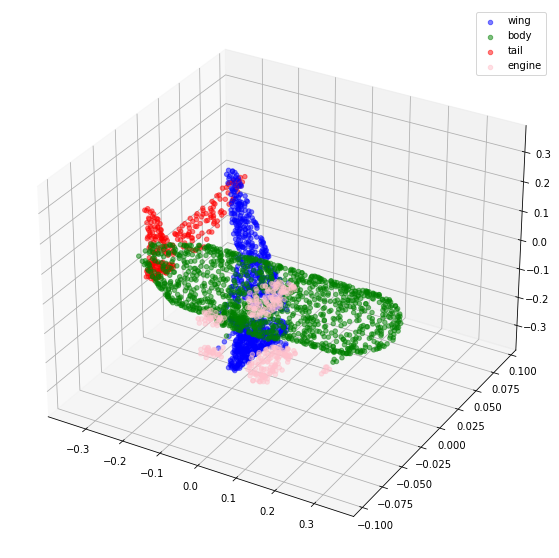

In [9]:
def visualize_data(point_cloud, labels):
    df = pd.DataFrame(
        data={
            "x": point_cloud[:, 0],
            "y": point_cloud[:, 1],
            "z": point_cloud[:, 2],
            "label": labels,
        }
    )
    fig = plt.figure(figsize=(15, 10))
    ax = plt.axes(projection="3d")
    for index, label in enumerate(LABELS):
        c_df = df[df["label"] == label]
        try:
            ax.scatter(
                c_df["x"], c_df["y"], c_df["z"], label=label, alpha=0.5, c=COLORS[index]
            )
        except IndexError:
            pass
    ax.legend()
    plt.show()


visualize_data(point_clouds[2], all_labels[2])
visualize_data(point_clouds[300], all_labels[300])